In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Data Prep

## Shelter Data

In [2]:
shelter_paths = ['/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2021.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2022.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2023.csv']

dataframes = [pd.read_csv(file) for file in shelter_paths]

# Load each file and verify its contents
for file in shelter_paths:
    try:
        df = pd.read_csv(file)
        if df.empty:
            print(f"The file at {file} is empty.")
        else:
            print(f"Loaded {len(df)} rows from {file}")
            dataframes.append(df)
    except FileNotFoundError:
        print(f"No file found at {file}")
    except pd.errors.EmptyDataError:
        print(f"File at {file} is empty or corrupted.")

# If all DataFrames are loaded correctly, concatenate them into one
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"The combined dataframe has {len(combined_df)} rows.")
else:
    print("No data has been loaded. Please check the file paths and contents.")

Loaded 50944 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2021.csv
Loaded 49478 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2022.csv
Loaded 48345 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2023.csv
The combined dataframe has 297534 rows.


In [3]:
combined_df = combined_df.dropna(subset=['CAPACITY_TYPE'])

# Separate data based on Capacity Type
bed_capacity_df = combined_df[combined_df['CAPACITY_TYPE'] == 'Bed Based Capacity'].copy()
room_capacity_df = combined_df[combined_df['CAPACITY_TYPE'] == 'Room Based Capacity'].copy()

# removing extra columns based on the capacity type
columns_to_drop = ['CAPACITY_TYPE', 'ORGANIZATION_NAME', 'SHELTER_GROUP', 'LOCATION_NAME', 'LOCATION_ADDRESS', 'LOCATION_CITY', 'LOCATION_PROVINCE', 'PROGRAM_NAME', 'ORGANIZATION_ID', 'SHELTER_ID', 'PROGRAM_ID']
bed_columns_to_drop = ['CAPACITY_ACTUAL_ROOM', 'CAPACITY_FUNDING_ROOM', 'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS', 'OCCUPANCY_RATE_ROOMS']
room_columns_to_drop = ['CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS', 'OCCUPANCY_RATE_BEDS']

bed_capacity_df = bed_capacity_df.drop(columns_to_drop, axis=1)
bed_capacity_df = bed_capacity_df.drop(bed_columns_to_drop, axis=1)

room_capacity_df = room_capacity_df.drop(columns_to_drop, axis=1)
room_capacity_df = room_capacity_df.drop(room_columns_to_drop, axis=1)

# Convert OCCUPANCY_DATE to datetime
bed_capacity_df['OCCUPANCY_DATE'] = pd.to_datetime(bed_capacity_df['OCCUPANCY_DATE'],format='mixed')
room_capacity_df['OCCUPANCY_DATE'] = pd.to_datetime(room_capacity_df['OCCUPANCY_DATE'],format='mixed')

# Extract year, month, and day as separate features
bed_capacity_df['YEAR'] = bed_capacity_df['OCCUPANCY_DATE'].dt.year
bed_capacity_df['MONTH'] = bed_capacity_df['OCCUPANCY_DATE'].dt.month
bed_capacity_df['DAY'] = bed_capacity_df['OCCUPANCY_DATE'].dt.day

room_capacity_df['YEAR'] = room_capacity_df['OCCUPANCY_DATE'].dt.year
room_capacity_df['MONTH'] = room_capacity_df['OCCUPANCY_DATE'].dt.month
room_capacity_df['DAY'] = room_capacity_df['OCCUPANCY_DATE'].dt.day

# Label Encoding
label_encoder = LabelEncoder()

categorical_columns = ['SECTOR', 'PROGRAM_MODEL', 'OVERNIGHT_SERVICE_TYPE', 'LOCATION_POSTAL_CODE', 'PROGRAM_AREA']

for column in categorical_columns:
    # Combine the data from both DataFrames (ensure consistency in encoding)
    combined_data = pd.concat([bed_capacity_df[column], room_capacity_df[column]], ignore_index=True)
    label_encoder.fit(combined_data)

    # Transform each dataframe separately
    bed_capacity_df[column] = label_encoder.transform(bed_capacity_df[column])
    room_capacity_df[column] = label_encoder.transform(room_capacity_df[column])

print(bed_capacity_df.head())
# print(room_capacity_df.head())

    _id OCCUPANCY_DATE  LOCATION_ID  LOCATION_POSTAL_CODE  SECTOR  \
5     6     2021-01-01       1051.0                    82       2   
10   11     2021-01-01       1029.0                   108       1   
11   12     2021-01-01       1102.0                   102       1   
21   22     2021-01-01       1009.0                    29       1   
25   26     2021-01-01       1065.0                     2       0   

    PROGRAM_MODEL  OVERNIGHT_SERVICE_TYPE  PROGRAM_AREA  SERVICE_USER_COUNT  \
5               0                       6             1                   6   
10              0                       6             1                  22   
11              0                       6             1                   8   
21              1                       6             1                  10   
25              0                       6             2                  11   

    CAPACITY_ACTUAL_BED  CAPACITY_FUNDING_BED  OCCUPIED_BEDS  UNOCCUPIED_BEDS  \
5                   8.0      

In [4]:
# Average Occupancy Rates
daily_avg_bed_occupancy = bed_capacity_df.groupby('OCCUPANCY_DATE')['OCCUPANCY_RATE_BEDS'].mean().reset_index()
daily_avg_room_occupancy = room_capacity_df.groupby('OCCUPANCY_DATE')['OCCUPANCY_RATE_ROOMS'].mean().reset_index()

In [5]:
# Single Shelter Example DF
bed_capacity_df_1051 = bed_capacity_df.loc[bed_capacity_df['LOCATION_ID'] == 1051.0]
# print(bed_capacity_df_1051.columns)
# print(bed_capacity_df_1051.head())

## Weather Data

In [6]:
weather_paths = ['/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2021_P1D.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2022_P1D.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2023_P1D.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2024_P1D.csv']

dataframes = [pd.read_csv(file) for file in weather_paths]

for file in weather_paths:
    try:
        weather_df = pd.read_csv(file)
        if df.empty:
            print(f"The file at {file} is empty.")
        else:
            print(f"Loaded {len(weather_df)} rows from {file}")
            dataframes.append(weather_df)
    except FileNotFoundError:
        print(f"No file found at {file}")
    except pd.errors.EmptyDataError:
        print(f"File at {file} is empty or corrupted.")

if dataframes:
    combined_weather_df = pd.concat(dataframes, ignore_index=True)
    print(f"The combined dataframe has {len(combined_weather_df)} rows.")
else:
    print("No data has been loaded. Please check the file paths and contents.")

columns_to_drop = ['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Data Quality', 'Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag']
weather_df = combined_weather_df.drop(columns_to_drop, axis=1)

print(weather_df.head())

Loaded 365 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2021_P1D.csv
Loaded 365 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2022_P1D.csv
Loaded 365 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2023_P1D.csv
Loaded 366 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2024_P1D.csv
The combined dataframe has 2922 rows.
    Date/Time  Year  Month  Day  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  \
0  2021-01-01  2021      1    1            2.5           -1.0             0.7   
1  2021-01-02  2021      1    2            2.2           -0.9             0.7   
2  2021-01-03  2021      1    3            2.1            0.2             1.1   
3  2021-01-04  2021      1    4            1.7           -0.1             0.8   
4  2021-01-05  2021      1    5            1.6            0.6             1.1   

   

# Prophet Code

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

In [7]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

## Combined Dataset

Here, I am testing how the model works at predicting the *overall* average shelter demand across all shelters in the city.

In [8]:
print(daily_avg_bed_occupancy.head())
df_prophet = daily_avg_bed_occupancy.reset_index().rename(columns={'OCCUPANCY_DATE': 'ds', 'OCCUPANCY_RATE_BEDS': 'y'})

  OCCUPANCY_DATE  OCCUPANCY_RATE_BEDS
0     2021-01-01            93.077159
1     2021-01-02            93.174659
2     2021-01-03            92.600568
3     2021-01-04            92.620455
4     2021-01-05            92.356932


### Single Feature
This version is ONLY trained on the occupancy dataset

In [22]:
df_single = daily_avg_bed_occupancy.reset_index().rename(columns={'OCCUPANCY_DATE': 'ds', 'OCCUPANCY_RATE_BEDS': 'y'})

m_single = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m_single.fit(df_single)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/24vhl_ft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/msas2mw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89067', 'data', 'file=/tmp/tmpy5ifwar3/24vhl_ft.json', 'init=/tmp/tmpy5ifwar3/msas2mw6.json', 'output', 'file=/tmp/tmpy5ifwar3/prophet_modelk1ewke1o/prophet_model-20240409023744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:37:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:37:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


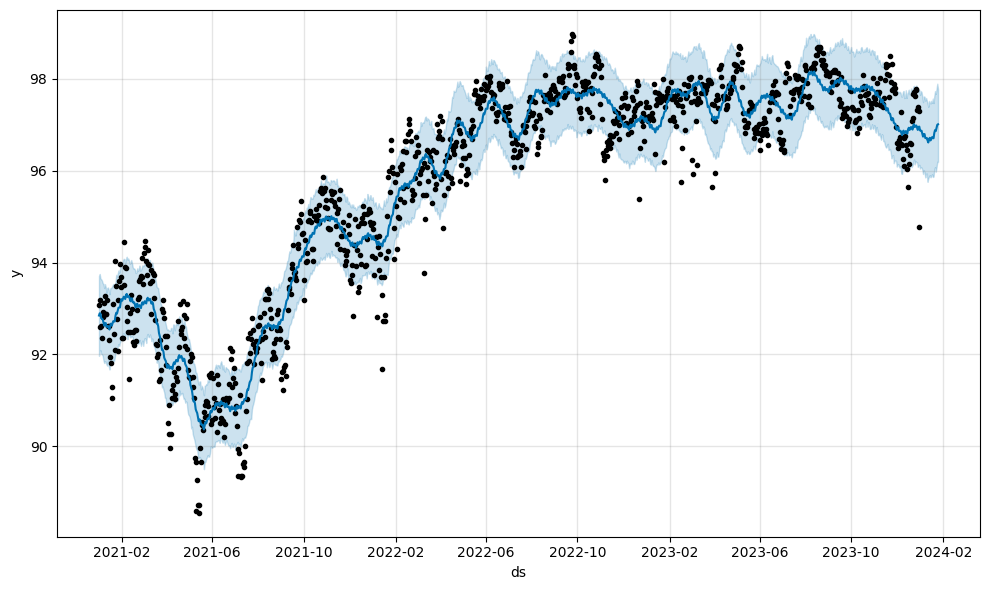

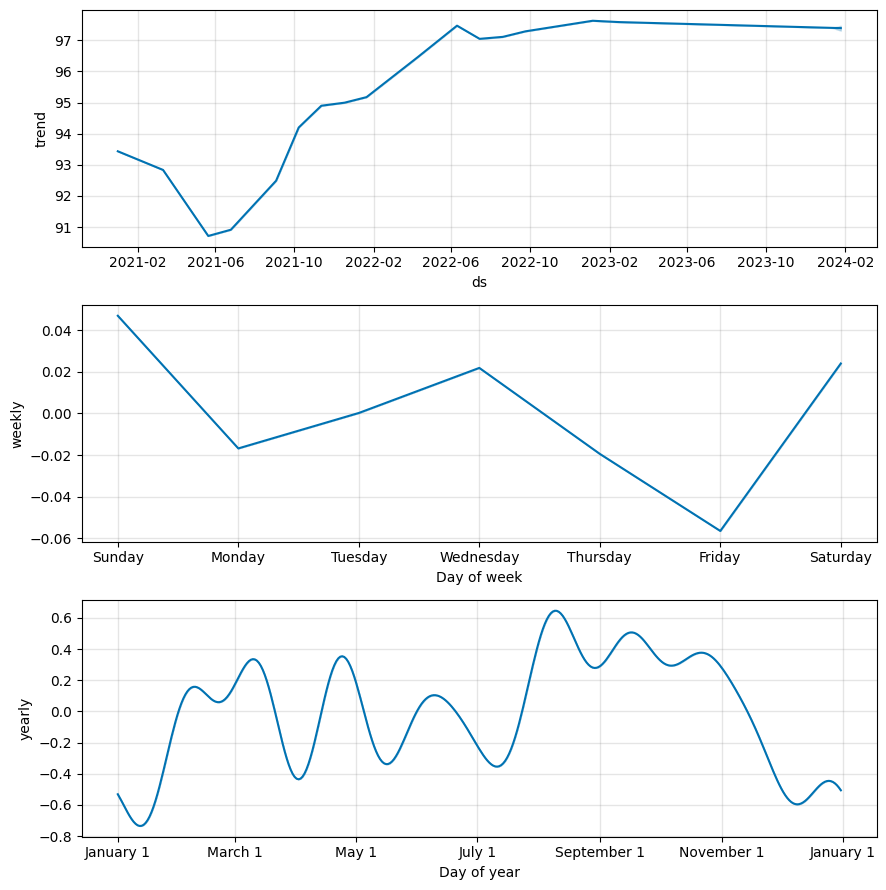

In [24]:
# forecasting
future = m_single.make_future_dataframe(periods=25) # For forecasting the next 12 months / 365 days
forecast = m_single.predict(future) # Make predictions

fig1 = m_single.plot(forecast)
fig2 = m_single.plot_components(forecast)

In [26]:
# Cross-validation
print("Cross-Validation Testing")
df_cv_single = cross_validation(m_single, initial='730 days', period='180 days', horizon='20 days')

# Performance metrics
df_p_single = performance_metrics(df_cv_single)
print(df_p_single.head())

INFO:prophet:Making 2 forecasts with cutoffs between 2023-06-14 00:00:00 and 2023-12-11 00:00:00


Cross-Validation Testing


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/ozt31zae.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/xp1imjb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92634', 'data', 'file=/tmp/tmpy5ifwar3/ozt31zae.json', 'init=/tmp/tmpy5ifwar3/xp1imjb1.json', 'output', 'file=/tmp/tmpy5ifwar3/prophet_modelg3niv9__/prophet_model-20240409024631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:46:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:46:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/t48iy989.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/i2dlxz9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  2 days  0.199914  0.447117  0.427614  0.004401  0.004481  0.004403   
1  3 days  0.321743  0.567224  0.565451  0.005822  0.006009  0.005824   
2  4 days  0.450984  0.671554  0.645516  0.006669  0.006048  0.006660   
3  5 days  0.985556  0.992752  0.928168  0.009620  0.009346  0.009591   
4  6 days  1.015867  1.007902  0.948886  0.009832  0.009562  0.009803   

   coverage  
0      1.00  
1      1.00  
2      0.75  
3      0.25  
4      0.25  


### Multiple Features
This version is trained on the occupancy dataset and weather (housing to come)

In [31]:
df_multi = df_prophet
df_multi['ds'] = pd.to_datetime(df_multi['ds'])
weather_df['Date/Time'] = pd.to_datetime(weather_df['Date/Time'])

df_multi = pd.merge(df_multi, weather_df[['Date/Time', 'Mean Temp (°C)']], left_on='ds', right_on='Date/Time', how='left')

df_multi.drop(columns=['Date/Time'], inplace=True)

df_multi.dropna(subset=['Mean Temp (°C)'], inplace=True)
df_multi.rename(columns={'Mean Temp (°C)': 'MEAN_TEMP_C'}, inplace=True)

print(df_multi.head())

   index         ds          y  MEAN_TEMP_C
0      0 2021-01-01  93.077159          0.7
1      0 2021-01-01  93.077159          0.7
2      1 2021-01-02  93.174659          0.7
3      1 2021-01-02  93.174659          0.7
4      2 2021-01-03  92.600568          1.1


In [32]:
m_multi = Prophet(yearly_seasonality=True, weekly_seasonality=True)

m_multi.add_regressor('MEAN_TEMP_C')

m_multi.fit(df_multi)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/0sqjhmy7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/5bpuv3cy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4960', 'data', 'file=/tmp/tmpy5ifwar3/0sqjhmy7.json', 'init=/tmp/tmpy5ifwar3/5bpuv3cy.json', 'output', 'file=/tmp/tmpy5ifwar3/prophet_modelc6hy_nqv/prophet_model-20240409025106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:51:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:51:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


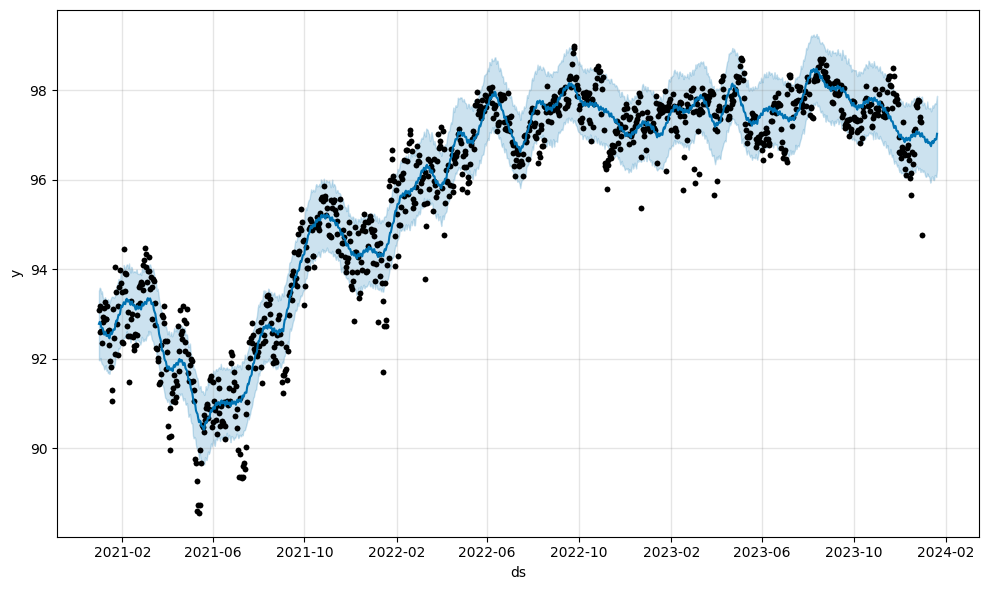

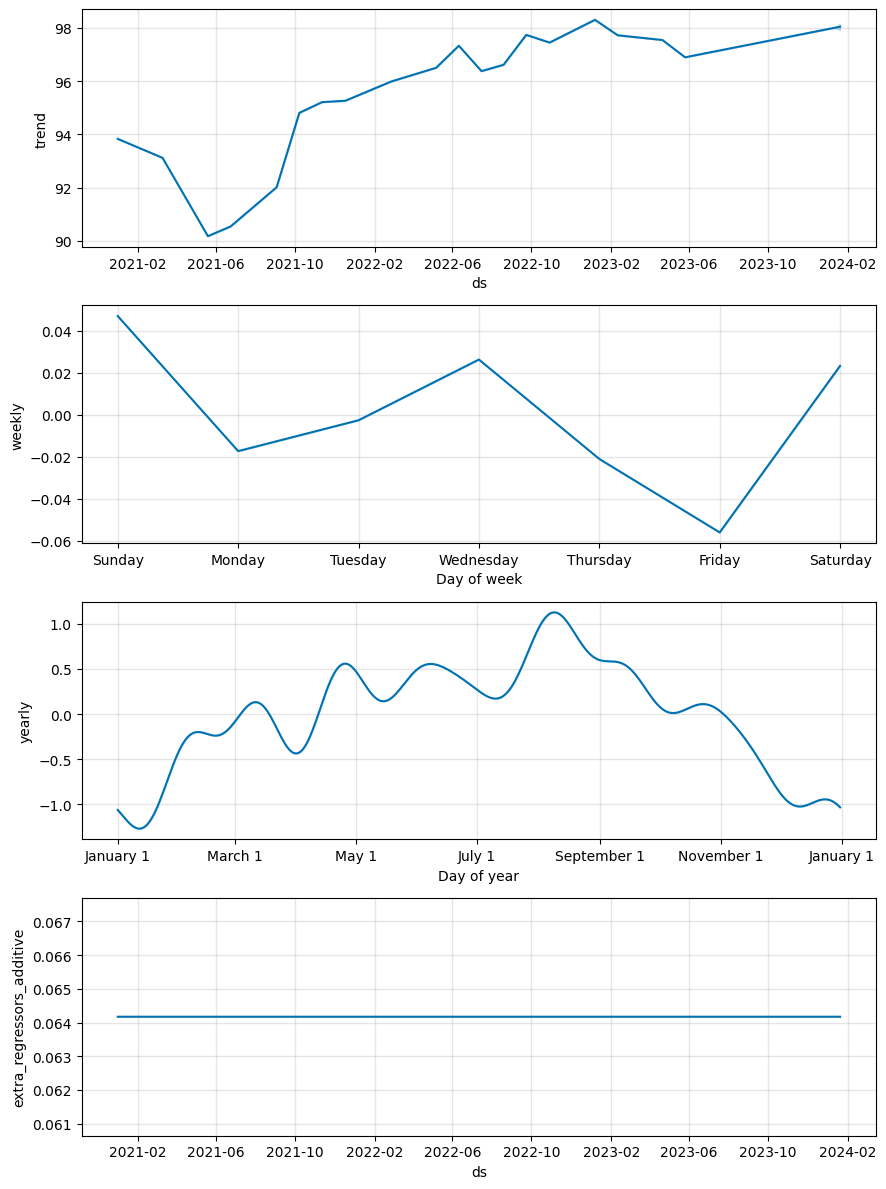

In [35]:
# forecasting
future = m_multi.make_future_dataframe(periods=20)

last_known_temp = df_multi['MEAN_TEMP_C'].iloc[-1]
future['MEAN_TEMP_C'] = last_known_temp

forecast = m_multi.predict(future)

# Plot the forecast
fig1 = m_multi.plot(forecast)
fig2 = m_multi.plot_components(forecast)

In [36]:
# Cross-validation
print("Cross-Validation Testing")
df_cv_multi = cross_validation(m_multi, initial='730 days', period='180 days', horizon='20 days')

# Performance metrics
df_p_multi = performance_metrics(df_cv_multi)
print(df_p_multi.head())

INFO:prophet:Making 2 forecasts with cutoffs between 2023-06-14 00:00:00 and 2023-12-11 00:00:00


Cross-Validation Testing


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/uhou8z1f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/xz3o3ndb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6333', 'data', 'file=/tmp/tmpy5ifwar3/uhou8z1f.json', 'init=/tmp/tmpy5ifwar3/xz3o3ndb.json', 'output', 'file=/tmp/tmpy5ifwar3/prophet_modelf0ks3qwj/prophet_model-20240409025347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:53:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:53:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/a8atv27a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/9sy81pnw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  2 days  0.532627  0.729813  0.703393  0.007237  0.007304  0.007247   
1  3 days  0.759443  0.871460  0.861353  0.008864  0.008967  0.008876   
2  4 days  0.899846  0.948602  0.940167  0.009699  0.009676  0.009699   
3  5 days  1.586210  1.259448  1.229483  0.012719  0.012440  0.012700   
4  6 days  1.669218  1.291982  1.270586  0.013142  0.012762  0.013124   

   coverage  
0     0.750  
1     0.375  
2     0.125  
3     0.000  
4     0.000  


### Comparing the Two

**Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):** These metrics are lower for the model without the weather data. Lower MSE and RMSE values indicate that the model's predictions are closer to the actual values, suggesting better performance.

**Mean Absolute Error (MAE):** MAE is lower for the model without the weather data, indicating that the average magnitude of errors in the predictions is smaller.

**Mean Absolute Percentage Error (MAPE) and Symmetric Mean Absolute Percentage Error (sMAPE):** These percentage-based metrics are also lower for the model without the weather data.

**Conclusion:** Based on the metrics identified above, the model ***without*** the weather feature is performing better for forecasting the target variable... This was not expected but suggests that more work needs to be done to incorperate weather. Further exploration and refinement could include experimenting with different transformations of the weather data, testing other external regressors, or adjusting the model's parameters.

## Individual Shelter
For this section, I have chosen a single shelter as an example (LOCATION_ID = 1051.0)

### Single Feature: Just Shelter Occupancy

In [52]:
specific_shelter_df = combined_df[combined_df['LOCATION_ID'] == 1051.0]
specific_shelter_df['OCCUPANCY_DATE'] = pd.to_datetime(specific_shelter_df['OCCUPANCY_DATE'],format='mixed')
# print(len(specific_shelter_df))
# print(specific_shelter_df.head())

<ipython-input-52-a52780bcdbe6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_shelter_df['OCCUPANCY_DATE'] = pd.to_datetime(specific_shelter_df['OCCUPANCY_DATE'],format='mixed')


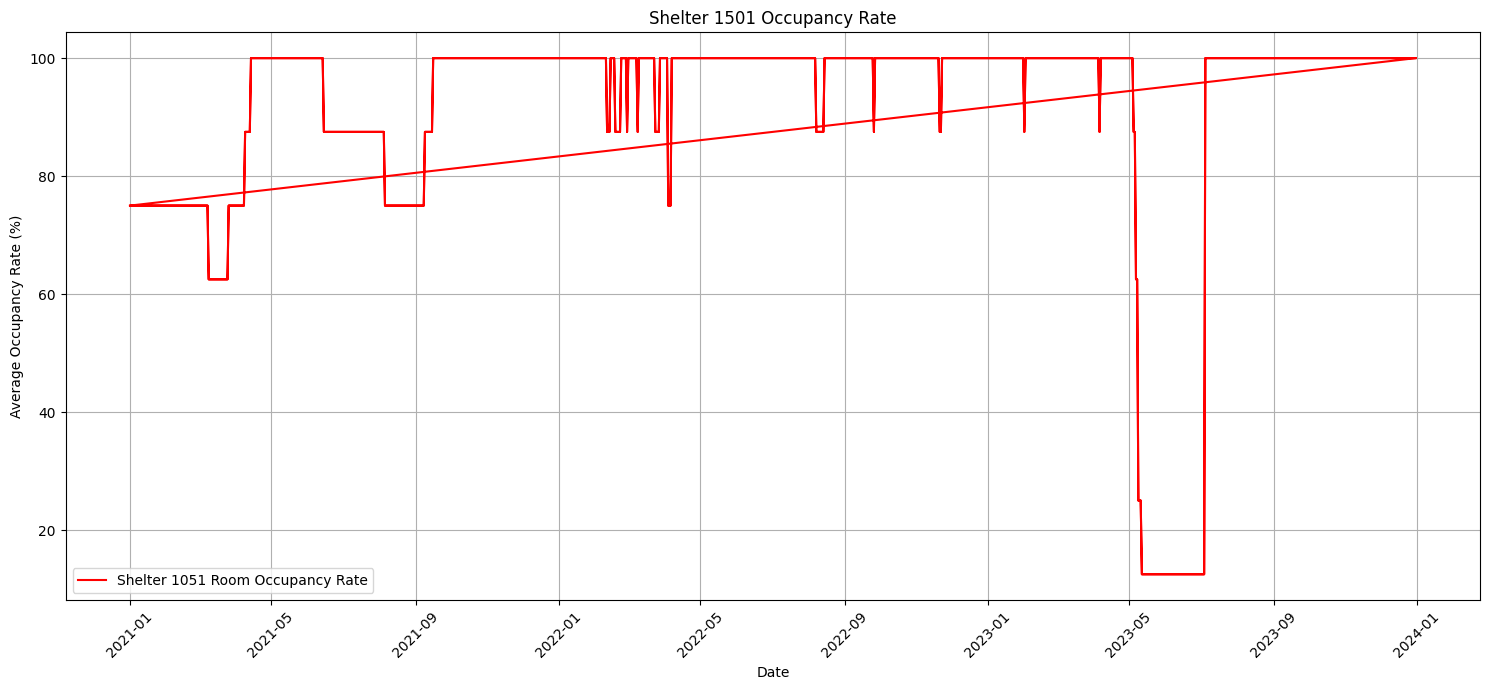

In [71]:
# PLOTTING AVERAGE DEMAND TO VISUALIZE -----------------------------------------

# Plotting
plt.figure(figsize=(15, 7))


# Plot for rooms
plt.plot(specific_shelter_df['OCCUPANCY_DATE'], specific_shelter_df['OCCUPANCY_RATE_BEDS'], label='Shelter 1051 Room Occupancy Rate', color='red')

plt.title('Shelter 1501 Occupancy Rate')
plt.xlabel('Date')
plt.ylabel('Average Occupancy Rate (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()

plt.show()

In [50]:
df_without_weather = specific_shelter_df.reset_index().rename(columns={'OCCUPANCY_DATE': 'ds', 'OCCUPANCY_RATE_BEDS': 'y'})

m_without = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m_without.fit(df_without_weather)

# Checking
print("Cross-Validation Testing")
df_cv_without = cross_validation(m_without, initial='730 days', period='180 days', horizon='10 days')
df_p_without = performance_metrics(df_cv_without)
print(df_p_without.head())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/ndlae_5r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/ttqevorv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35620', 'data', 'file=/tmp/tmpy5ifwar3/ndlae_5r.json', 'init=/tmp/tmpy5ifwar3/ttqevorv.json', 'output', 'file=/tmp/tmpy5ifwar3/prophet_modelv6n2mf3j/prophet_model-20240409032306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:23:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:23:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2023-06-24 00:00:00 and 2023-12-21 00:00:00


Cross-Validation Testing


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/w733wi8g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/9mhfqxg0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83080', 'data', 'file=/tmp/tmpy5ifwar3/w733wi8g.json', 'init=/tmp/tmpy5ifwar3/9mhfqxg0.json', 'output', 'file=/tmp/tmpy5ifwar3/prophet_modelkx1ybv_m/prophet_model-20240409032307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:23:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/y8934buj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/98jnls8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  horizon         mse       rmse        mae      mape     mdape     smape  \
0  1 days  112.070280  10.586325  10.558291  0.502070  0.502070  0.875241   
1  2 days  134.133735  11.581612  11.506749  0.563818  0.563818  1.048489   
2  3 days  156.608597  12.514336  12.369194  0.623129  0.623129  1.049740   
3  4 days  173.849261  13.185191  12.985113  0.664419  0.664419  1.050769   
4  5 days  186.766152  13.666241  13.438365  0.691710  0.691710  1.051922   

   coverage  
0       0.5  
1       0.5  
2       0.5  
3       0.5  
4       0.5  


### Multiple Features: Occupancy and Weather

In [66]:
df_with = specific_shelter_df

df_with = specific_shelter_df.reset_index().rename(columns={'OCCUPANCY_DATE': 'ds', 'OCCUPANCY_RATE_BEDS': 'y'})

weather_df['Date/Time'] = pd.to_datetime(weather_df['Date/Time'])

df_with = pd.merge(df_with, weather_df[['Date/Time', 'Mean Temp (°C)']], left_on='ds', right_on='Date/Time', how='left')

df_with.drop(columns=['Date/Time'], inplace=True)
df_with.dropna(subset=['Mean Temp (°C)'], inplace=True)
df_with.rename(columns={'Mean Temp (°C)': 'MEAN_TEMP_C'}, inplace=True)

# print(df_with.head())

In [69]:
m_with = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m_with.add_regressor('MEAN_TEMP_C')
m_with.fit(df_with)

# Checking
print("Cross-Validation Testing")
df_cv_with = cross_validation(m_with, initial='730 days', period='180 days', horizon='10 days')
df_p_with = performance_metrics(df_cv_with)
print(df_p_with.head())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/83dwgy1j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/qxze6ts2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8582', 'data', 'file=/tmp/tmpy5ifwar3/83dwgy1j.json', 'init=/tmp/tmpy5ifwar3/qxze6ts2.json', 'output', 'file=/tmp/tmpy5ifwar3/prophet_model4y_rllln/prophet_model-20240409033335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:33:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2023-06-24 00:00:00 and 2023-12-21 00:00:00


Cross-Validation Testing


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/6maw8wfg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/apaea487.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11384', 'data', 'file=/tmp/tmpy5ifwar3/6maw8wfg.json', 'init=/tmp/tmpy5ifwar3/apaea487.json', 'output', 'file=/tmp/tmpy5ifwar3/prophet_modelutxpsfpe/prophet_model-20240409033338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:33:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/zvvpby5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5ifwar3/f5_pyzo6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  horizon         mse       rmse        mae      mape     mdape     smape  \
0  1 days  146.540891  12.105408  11.350057  0.658073  0.658073  1.034474   
1  2 days  169.737938  13.028351  12.056964  0.715336  0.715336  1.034379   
2  3 days  194.783329  13.956480  12.779163  0.771425  0.771425  1.034604   
3  4 days  212.917604  14.591696  13.266864  0.809641  0.809641  1.034710   
4  5 days  226.494297  15.049727  13.665174  0.835620  0.835620  1.035493   

   coverage  
0       0.5  
1       0.5  
2       0.5  
3       0.5  
4       0.5  


### Comparing the Two

For the specific shelter (LOCATION_ID = 1051.0), the model's performance was evaluated both with and without incorporating weather data as an external regressor. Here are the results from this analysis.....

**Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):** For all forecast horizons (1 to 5 days), both MSE and RMSE metrics are consistently **lower** for the model that **does not** include weather data.

**Mean Absolute Error (MAE):** MAE is lower for the model without weather data across all days. This suggests that the forecasts from the model without the weather feature are generally closer to the true values.

**Mean Absolute Percentage Error (MAPE) and Symmetric Mean Absolute Percentage Error (sMAPE):** Both MAPE and sMAPE are lower for the model excluding weather data, indicating that, proportionally, its predictions are closer to the actual values when compared to the model that includes weather as an external regressor.

Conclusion
In the context of forecasting for the specific shelter (LOCATION_ID = 1051.0), the model that does not incorporate weather data outperforms the model that does, across several key metrics... This is not the performance we were expecting however it aligns with the performance seen above. We will need to test more to figure out why this is, and how we can get it to perform better.